C:\Users\20114\AppData\Local\Temp\ipykernel_23592\1072169544.py:83: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


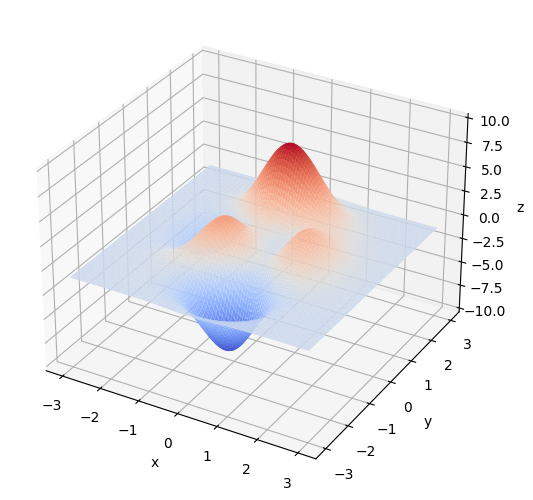

max_fitness: 0.0066499663217461915
最优的基因型： [1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 0
 0 1 0 1 1 1 0 1 1 1 1]
(x, y): (0.0015605092978780988, 1.5695227724029284)


In [3]:
#遗传算法
# 进化算法、群优化，在解空间中同时搜索多个可行解，经过演化得到
# 每一代使用fitness function来评价某个解是否达到了最优，并筛掉一部分
# 3个算子：
# 	选择【选择个体的组合，优良个体被选中的概率比较大】、
# 	交叉【保存父代的一些优良特性，同时又有一些变化】、
# 	变异【一定概率修改变量值，保证多样性】
# 步骤：
# 	编码【解空间中的解映射到遗传空间的基因串上】
# 	初始种群生成【选择N个基因串，N太小进化时间长；N太大不同解之间会相似，失去意义】
# 	适应度评估【根据任务，设计fitness function】
# 	选择【比如采用轮盘赌的方式选择优良个体】
# 	交叉【最主要的遗传操作、体现信息交换的思想】
# 	变异【概率相对更小】
# 以上步骤执行完生成新一代，如此循环，终止条件可以是相邻两代之间的最优解优化程度小于某一值


import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

DNA_SIZE = 24#个体大小
POP_SIZE = 200#种群数量
CROSSOVER_RATE = 0.8#一定概率交叉，就是接受母亲基因
MUTATION_RATE = 0.005#一定概率变异
N_GENERATIONS = 50#迭代次数
X_BOUND = [-3, 3]#X取值范围
Y_BOUND = [-3, 3]


def F(x, y):
	return 3*(1-x)**2*np.exp(-(x**2)-(y+1)**2)- 10*(x/5 - x**3 - y**5)*np.exp(-x**2-y**2)- 1/3**np.exp(-(x+1)**2 - y**2)

def plot_3d(ax):

	X = np.linspace(*X_BOUND, 100)
	Y = np.linspace(*Y_BOUND, 100)
	X,Y = np.meshgrid(X, Y)
	Z = F(X, Y)
	ax.plot_surface(X,Y,Z,rstride=1,cstride=1,cmap=cm.coolwarm)
	ax.set_zlim(-10,10)
	ax.set_xlabel('x')
	ax.set_ylabel('y')
	ax.set_zlabel('z')
	plt.pause(3)
	plt.show()


def get_fitness(pop): 
    x,y = translateDNA(pop)
    pred = F(x,y)
    return (pred - np.min(pred)) + 1e-3 
#减去最小的适应度是为了防止适应度出现负数，通过这一步fitness的范围为[0, np.max(pred)-np.min(pred)],最后在加上一个很小的数防止出现为0的适应度

# 编码
def translateDNA(pop): #pop表示种群矩阵，一行表示一个二进制编码表示的DNA，矩阵的行数为种群数目
	x_pop = pop[:,1::2]#奇数列表示X
	y_pop = pop[:,::2] #偶数列表示y
	
	#pop:(POP_SIZE,DNA_SIZE)*(DNA_SIZE,1) --> (POP_SIZE,1)
    #dot表示乘法
	x = x_pop.dot(2**np.arange(DNA_SIZE)[::-1])/float(2**DNA_SIZE-1)*(X_BOUND[1]-X_BOUND[0])+X_BOUND[0]
	y = y_pop.dot(2**np.arange(DNA_SIZE)[::-1])/float(2**DNA_SIZE-1)*(Y_BOUND[1]-Y_BOUND[0])+Y_BOUND[0]
	return x,y

# 交叉变异
def crossover_and_mutation(pop, CROSSOVER_RATE = 0.8):
	new_pop = []
	for father in pop:		#遍历种群中的每一个个体，将该个体作为父亲
		child = father		#孩子先得到父亲的全部基因（这里我把一串二进制串的那些0，1称为基因）
		if np.random.rand() < CROSSOVER_RATE:			#产生子代时不是必然发生交叉，而是以一定的概率发生交叉
			mother = pop[np.random.randint(POP_SIZE)]	#再种群中选择另一个个体，并将该个体作为母亲
			cross_points = np.random.randint(low=0, high=DNA_SIZE*2)	#随机产生交叉的点
			child[cross_points:] = mother[cross_points:]		#孩子得到位于交叉点后的母亲的基因
		mutation(child)	#每个后代有一定的机率发生变异
		new_pop.append(child)

	return new_pop

def mutation(child, MUTATION_RATE=0.003):
	if np.random.rand() < MUTATION_RATE: 				#以MUTATION_RATE的概率进行变异
		mutate_point = np.random.randint(0, DNA_SIZE*2)	#随机产生一个实数，代表要变异基因的位置
		child[mutate_point] = child[mutate_point]^1 	#将变异点的二进制为反转

def select(pop, fitness):    # nature selection wrt pop's fitness
    idx = np.random.choice(np.arange(POP_SIZE), size=POP_SIZE, replace=True,
                           p=(fitness)/(fitness.sum()) )
    return pop[idx]

def print_info(pop):
	fitness = get_fitness(pop)
	max_fitness_index = np.argmax(fitness)
	print("max_fitness:", fitness[max_fitness_index])
	x,y = translateDNA(pop)
	print("最优的基因型：", pop[max_fitness_index])
	print("(x, y):", (x[max_fitness_index], y[max_fitness_index]))


if __name__ == "__main__":
	fig = plt.figure()
	ax = Axes3D(fig)	
	plt.ion()#将画图模式改为交互模式，程序遇到plt.show不会暂停，而是继续执行
	plot_3d(ax)

	pop = np.random.randint(2, size=(POP_SIZE, DNA_SIZE*2)) #matrix (POP_SIZE, DNA_SIZE)
	for _ in range(N_GENERATIONS):#迭代N代
		x,y = translateDNA(pop)
		if 'sca' in locals(): 
			sca.remove()
		sca = ax.scatter(x, y, F(x,y), c='black', marker='o');plt.show();plt.pause(0.1)
		pop = np.array(crossover_and_mutation(pop, CROSSOVER_RATE))
		F_values = F(translateDNA(pop)[0], translateDNA(pop)[1])#x, y --> Z matrix
		fitness = get_fitness(pop)
		pop = select(pop, fitness) #选择生成新的种群
	
	print_info(pop)
	plt.ioff()
	plot_3d(ax)
